<a href="https://colab.research.google.com/github/blancavazquez/Analisis-datos-masivos-2024/blob/main/notebooks/4_modelado_factor_latente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de recomendación de libros

El objetivo de esta libreta es construir un sistema de recomendación de libros basado en filtrado colaborativo. Para lograr esto se construirá un modelo de factor latente (LFM, por sus siglas en inglés) y la tećnica de optimización que se usará es el descenso del gradiente estocástico.

Los pasos a realizar en la construcción del sistema de recomendación son:

1. Análisis de los datos
2. Construcción de la matriz de ratings
3. Inicializar la matriz de factores
4. Calcular el error usando el error cuadrático medio
5. Minimizar el error usando el descenso del gradiente
6. Generación de las recomendaciones

Recordemos:

* Las variables latentes son las variables que no se observan directamente sino que son inferidas (a través de un modelo matemático) a partir de otras variables que se observan (medidos directamente).

Los modelos matemáticos que tratan de explicar las variables observadas en términos de variables latentes se llaman **modelos de factor latente**.

Una ventaja de utilizar variables latentes es que reduce la dimensionalidad de los datos.

### 1. Análisis de los datos

In [11]:
"""Carga de bibliotecas"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
"""Carga de la base de datos de libros"""
books = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Books.csv', sep=',', encoding="latin-1")
print("Tamaño de la bd de libros: ", books.shape)
print("Número de libros únicos: ",(books.bookISBN.unique().size))

books.head() #damos un vistazo a los datos

Tamaño de la bd de libros:  (3000, 8)
Número de libros únicos:  3000


,Unnamed: 0.1,Unnamed: 0,bookISBN,bookName,author,yearOfPublication,publisher,urlId
0,62044,26575,1551669382,Enchanted Afternoon,Susan Wiggs,2002,Mira,120656.0
1,85751,1995,0743202961,Every Breath You Take : A True Story of Obsess...,Ann Rule,2001,Free Press,116803.0
2,122688,7677,067151699X,The HIDDEN LIFE OF DOGS,Elizabeth Marshall Thomas,1995,Pocket,1805.0
3,87360,36120,0804108528,Inadmissible Evidence,Philip Friedman,1993,Ivy Books,139375.0
4,73712,30238,0061094145,"The Fifth Dominion (Imajica, Book 1)",Clive Barker,1995,HarperTorch,141585.0


In [14]:
#selección de variables de interés
df_books = books[['bookISBN','bookName','author','yearOfPublication','publisher']]
df_books

,bookISBN,bookName,author,yearOfPublication,publisher
0,1551669382,Enchanted Afternoon,Susan Wiggs,2002,Mira
1,0743202961,Every Breath You Take : A True Story of Obsess...,Ann Rule,2001,Free Press
2,067151699X,The HIDDEN LIFE OF DOGS,Elizabeth Marshall Thomas,1995,Pocket
3,0804108528,Inadmissible Evidence,Philip Friedman,1993,Ivy Books
4,0061094145,"The Fifth Dominion (Imajica, Book 1)",Clive Barker,1995,HarperTorch
...,...,...,...,...,...
2995,0842314296,Hinds' Feet on High Places,Hannah Hurnard,1997,Living Books
2996,0380774933,Keeper of the Heart,Johanna Lindsey,1993,Avon
2997,0451459407,"Death Masks (The Dresden Files, Book 5)",Jim Butcher,2003,Roc
2998,0064440028,Danny and the Dinosaur,Syd Hoff,1992,HarperTrophy


In [15]:
"""Carga de la base de datos de usuarios"""
users = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Users.csv', sep=',', encoding="latin-1")

print("Tamaño de la bd de usuarios: ", users.shape)
print("Número de usuarios únicos: ",(users.user.unique().size))

users.head() #damos un vistazo a los datos

Tamaño de la bd de usuarios:  (1000, 5)
Número de usuarios únicos:  1000


,Unnamed: 0.1,Unnamed: 0,user,location,age
0,57300,43156,43157.0,"windsor, ontario, canada",22.0
1,40638,99031,99032.0,"white plains, new york, usa",25.0
2,54265,42882,42883.0,"the woodlands, texas, usa",51.0
3,83797,183799,183800.0,"quebec, quebec, canada",29.0
4,96743,188795,188796.0,"toronto, ontario, canada",NaN


In [16]:
#selección de variables de interés
df_users = users[['user','location', 'age']]
df_users.head(10)

,user,location,age
0,43157.0,"windsor, ontario, canada",22.0
1,99032.0,"white plains, new york, usa",25.0
2,42883.0,"the woodlands, texas, usa",51.0
3,183800.0,"quebec, quebec, canada",29.0
4,188796.0,"toronto, ontario, canada",NaN
5,182393.0,"the center of, my own little world, usa",35.0
6,50547.0,"toronto, ontario, canada",32.0
7,264903.0,"dortmund, nordrhein-westfalen, germany",36.0
8,182442.0,"ithaca, new york, usa",NaN
9,258913.0,"zaberfeld, baden-wuerttemberg, germany",25.0


In [17]:
"""Carga de la base de datos de transacciones"""
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/UserEvents.csv', sep=',', encoding="latin-1")

print("Tamaño de la bd de transacciones: ", ratings.shape)
print("Número de libros únicos: ",(ratings.user.unique().size))
print("Número de usuarios únicos: ",(ratings.bookId.unique().size))
ratings.head(10) #damos un vistazo a los datos

Tamaño de la bd de transacciones:  (141081, 4)
Número de libros únicos:  13030
Número de usuarios únicos:  11234


,Unnamed: 0,user,bookId,impression
0,16,276747,0060517794,checkout
1,19,276747,0671537458,checkout
2,20,276747,0679776818,add to cart
3,133,276822,0060096195,checkout
4,137,276822,0375821813,checkout
5,141,276822,0552546933,checkout
6,145,276822,0786817070,checkout
7,174,276847,3257200552,view
8,177,276847,3404148576,add to cart
9,179,276847,3423071516,checkout


In [18]:
#selección de variables de interés
df_ratings= ratings[['user','bookId', 'impression']]
df_ratings = df_ratings.rename({'user': 'userId','impression':'score'}, axis=1)
df_ratings.head(10)

,userId,bookId,score
0,276747,0060517794,checkout
1,276747,0671537458,checkout
2,276747,0679776818,add to cart
3,276822,0060096195,checkout
4,276822,0375821813,checkout
5,276822,0552546933,checkout
6,276822,0786817070,checkout
7,276847,3257200552,view
8,276847,3404148576,add to cart
9,276847,3423071516,checkout


Text(0, 0.5, 'Number of users')

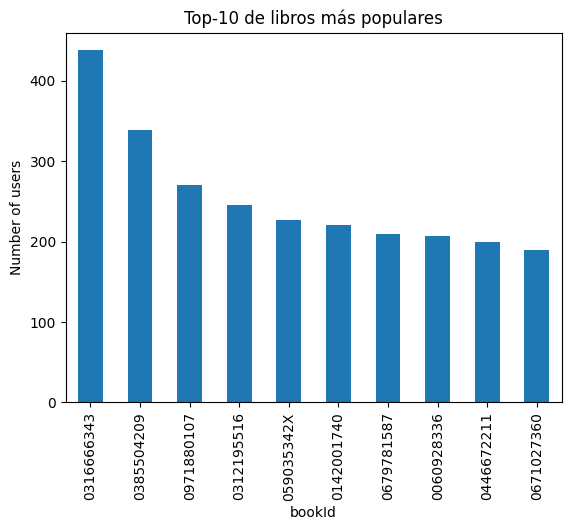

In [19]:
cpdel = df_ratings['bookId'].value_counts()[:10].plot(kind='bar',title='Top-10 de libros más populares')
plt.xlabel('bookId')
plt.ylabel('Number of users')

Text(0, 0.5, 'Number of books')

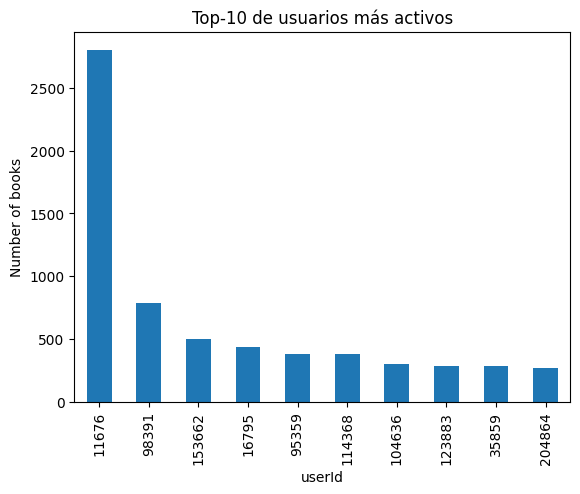

In [20]:
cpdel = df_ratings['userId'].value_counts()[:10].plot(kind='bar',title='Top-10 de usuarios más activos')
plt.xlabel('userId')
plt.ylabel('Number of books')

Text(0, 0.5, 'Number of cases')

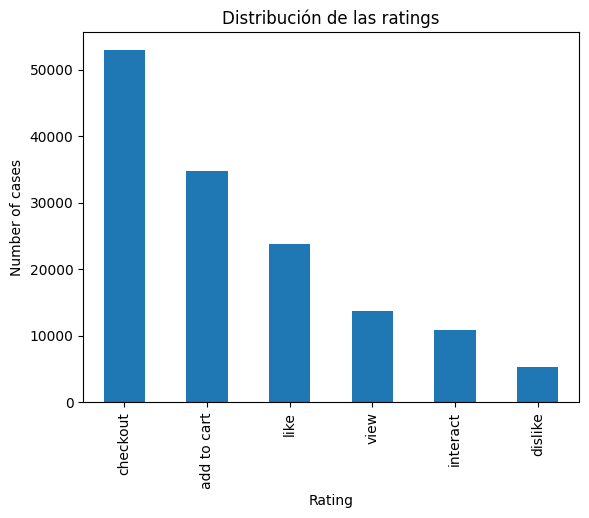

In [21]:
cpdel = df_ratings['score'].value_counts()[:10].plot(kind='bar',title='Distribución de las ratings')
plt.xlabel('Rating')
plt.ylabel('Number of cases')

In [22]:
"""Convertir los ratings a un valor numérico: no le gustó= 1,...,pago=6"""
df_ratings["score"] = ratings["impression"].map({"dislike":1,"view":2,"interact":3,
                                                 "like":4, "add to cart":5, "checkout":6})
df_ratings.head(10)

,userId,bookId,score
0,276747,0060517794,6
1,276747,0671537458,6
2,276747,0679776818,5
3,276822,0060096195,6
4,276822,0375821813,6
5,276822,0552546933,6
6,276822,0786817070,6
7,276847,3257200552,2
8,276847,3404148576,5
9,276847,3423071516,6


In [23]:
"""Promediar el rating"""
avg_rating = pd.DataFrame(df_ratings.groupby('bookId')['score'].mean()) #generamos df agrupando por libro y rating
avg_rating['counting'] = pd.DataFrame(ratings.groupby('bookId')['impression'].count()) #añadimos columna "ratingCount"
avg_rating.sort_values('counting', ascending=False).head(10) #ordenar el top-10

,score,counting
bookId,,
0316666343,5.061644,438
0385504209,5.227139,339
0971880107,1.996296,270
0312195516,5.077236,246
059035342X,5.511013,227
0142001740,5.176471,221
0679781587,5.223810,210
0060928336,4.801932,207
0446672211,5.000000,200


### 2. Construcción de la matriz de ratings

In [24]:
"""Usando la función pivote, creamos la matriz de ratings (R)"""

ratings_pivote = df_ratings.pivot(index='userId',columns = 'bookId',values='score').fillna(0)
print("Tamaño de la matriz R: ",ratings_pivote.shape)
ratings_pivote.head(10)

Tamaño de la matriz R:  (13030, 11234)


bookId,0002005018,0002251760,0002259001,0003300277,0006374921,0006480764,000648302X,0006485014,0006485200,0006493580,...,950491036X,9580464162,9722015184,9722020609,9726101794,9726106141,9726116902,9727722458,9770390107900,9871138148
userId,,,,,,,,,,,,,,,,,,,,,
8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
#visualizamos la matriz de ratings
ratings_pivote.values

array([[2., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
"""Extracción de usuarios y libros para representarlos como listas (y las reservamos) """
user_lista = list(ratings_pivote.index)
book_lista = list(ratings_pivote.columns)

In [27]:
from scipy.sparse import coo_matrix

"""Construir una matriz dispersa"""
R = coo_matrix(ratings_pivote.values)
print ("Tamaño de la matriz R", R.shape)

Tamaño de la matriz R (13030, 11234)


### 3. Inicializar la matriz de factores

In [28]:
"""Inicializar las matrices U y V"""
M, N = R.shape

print("Tamaño de las matrices M y N: ", M, N)
K = 3 #no. de factores a calcular

Tamaño de las matrices M y N:  13030 11234


In [29]:
U=np.random.rand(M,K) #inicializar la matriz U
V=np.random.rand(K,N) #inicializar la matriz V

print("Tamaño de la matriz U: ", U.shape)
print("Tamaño de la matriz V: ", V.shape)

Tamaño de la matriz U:  (13030, 3)
Tamaño de la matriz V:  (3, 11234)


In [30]:
print("Matriz U: \n", U)

Matriz U: 
 [[0.61902391 0.1412859  0.18246069]
 [0.19763436 0.68602401 0.74566263]
 [0.96734353 0.27392422 0.72819116]
 ...
 [0.7886329  0.55593372 0.71860289]
 [0.03519235 0.86359294 0.00134032]
 [0.23464106 0.05899554 0.88888684]]


In [31]:
print("Matriz V: \n", V)

Matriz V: 
 [[0.11797365 0.94777824 0.8339721  ... 0.67129437 0.10449715 0.6627029 ]
 [0.92707484 0.26892677 0.84723108 ... 0.41488341 0.4451318  0.13121426]
 [0.34374807 0.48153928 0.19520374 ... 0.58108013 0.92797891 0.70886304]]


### 4. Calcular el error usando error cuadrático medio
El error cuadrático medio (MSE, por sus siglas en inglés) mide la cantidad de error que hay entre dos conjuntos de datos, es decir, entre el valor real y el valor predicho.

In [32]:
"""Función para calcular el error cuadrático"""
from numpy.linalg import norm
def error(R,U,V,lamda=0.02):
    ratings = R.data
    filas = R.row
    columnas = R.col
    e = 0
    for ui in range(len(ratings)):
        rui=ratings[ui]
        u = filas[ui]
        i = columnas[ui]
        if rui>0:
            e = e + pow(rui-np.dot(U[u,:],V[:,i]),2)+\
                lamda*(pow(norm(U[u,:]),2)+pow(norm(V[:,i]),2))
    return e

### 5. Minimizar el error usando el descenso del gradiente

El algoritmo del descenso del gradiente es un método general de minimización para cualquier función $f$.

Para medir que tan bien nuestros parámetros definen a nuestra salida podemos definir una función de costo $J(\theta)$ que mida la diferencia entre las salidas originales y las salidas producidas por el modelo.

In [33]:
"""Función para optimizar las matrices U y V usando el SGD"""

def SGD(R, K, lamda=0.02,steps=10, gamma=0.001):
    M,N = R.shape
    U = np.random.rand(M,K)
    V = np.random.rand(K,N)

    rmse = np.sqrt(error(R,U,V,lamda)/len(R.data))
    print("RMSE inicial: "+str(rmse))

    for step in range(steps):
        for ui in range(len(R.data)):
            rui=R.data[ui]
            u = R.row[ui]
            i = R.col[ui]
            if rui>0:
                eui=rui-np.dot(U[u,:],V[:,i])
                U[u,:]= U[u,:]+gamma*2*(eui*V[:,i]-lamda*U[u,:])
                V[:,i]= V[:,i]+gamma*2*(eui*U[u,:]-lamda*V[:,i])
                #print("R:", R)
        rmse = np.sqrt(error(R,U,V,lamda)/len(R.data))
        if rmse<0.5:
            break
    print("RMSE final: "+str(rmse))
    return U,V

In [34]:
U,V=SGD(R,K=3,gamma=0.0007,lamda=0.001, steps=100)

RMSE inicial: 4.15714672026901
RMSE final: 1.0835554342492653


In [35]:
#Generar las predicciones para todos los usuarios
pred_user_ratings =np.matmul(U, V) #factorización de matrices

In [36]:
"""Convertir la matriz reconstruida a dataframe"""
df_pred_user_ratings = pd.DataFrame(np.round(pred_user_ratings,3),columns=book_lista, index=user_lista)#redondear los ratings a 3 dígitos
print("Tamaño de la matriz reconstruida: ", df_pred_user_ratings.shape)

Tamaño de la matriz reconstruida:  (13030, 11234)


#### Recuerda:
El dataframe 'df_pred_user_ratings' es la matriz reconstruida de U*V, donde: $M$ es el número de usuarios y $N$ es el número de productos.

*   Cada $r_{ij}$ es la predicción del usuario $i$ para el libro $j$.
*   Cuando $r_{ij}$ tiene un valor alto indica una alta probabilidad que el usuario compre un libro.

In [37]:
#Visualizar la matriz reconstruida
df_pred_user_ratings.head(10)

,0002005018,0002251760,0002259001,0003300277,0006374921,0006480764,000648302X,0006485014,0006485200,0006493580,...,950491036X,9580464162,9722015184,9722020609,9726101794,9726106141,9726116902,9727722458,9770390107900,9871138148
8,2.493,2.853,3.240,2.867,3.109,1.450,2.649,2.175,2.811,2.378,...,3.291,2.816,2.877,1.813,2.043,3.149,2.323,2.322,2.884,3.039
99,4.141,4.591,5.082,4.548,4.904,2.305,4.289,3.349,4.506,3.756,...,5.151,4.373,4.619,3.009,3.150,4.983,3.800,3.634,4.581,4.834
114,6.232,6.623,6.889,6.433,6.822,3.228,6.251,4.328,6.465,5.262,...,7.091,5.814,6.539,4.521,4.173,6.828,5.693,5.088,6.413,6.824
232,3.465,3.815,3.933,3.772,3.977,1.848,3.585,2.455,3.739,3.087,...,4.180,3.343,3.680,2.513,2.455,3.839,3.298,3.077,3.683,3.955
242,4.867,5.600,6.018,5.647,6.013,2.764,5.215,3.882,5.516,4.653,...,6.387,5.197,5.429,3.533,3.850,5.800,4.725,4.686,5.516,5.905
243,4.246,4.976,5.536,5.055,5.435,2.499,4.611,3.664,4.913,4.186,...,5.793,4.822,4.894,3.086,3.562,5.322,4.107,4.195,4.984,5.303
244,4.060,4.811,5.391,4.912,5.289,2.424,4.450,3.587,4.756,4.073,...,5.651,4.710,4.731,2.951,3.489,5.167,3.954,4.096,4.837,5.146
254,4.399,5.400,5.675,5.603,5.897,2.628,4.994,3.602,5.353,4.616,...,6.371,4.953,5.003,3.191,3.811,5.323,4.622,4.879,5.274,5.742
300,3.076,3.398,3.764,3.360,3.625,1.707,3.176,2.481,3.334,2.775,...,3.803,3.236,3.426,2.236,2.326,3.696,2.812,2.676,3.391,3.575
383,4.676,5.101,5.527,5.016,5.378,2.535,4.784,3.585,4.997,4.129,...,5.627,4.724,5.102,3.397,3.396,5.442,4.280,3.990,5.037,5.329


### 6. Generación de las recomendaciones

In [38]:
#Transponer la matriz reconstruida
trans_pred_user_ratings=df_pred_user_ratings.transpose()
trans_pred_user_ratings.head()

,8,99,114,232,242,243,244,254,300,383,...,278563,278565,278582,278633,278663,278668,278694,278843,278851,278854
0002005018,2.493,4.141,6.232,3.465,4.867,4.246,4.060,4.399,3.076,4.676,...,3.828,3.574,4.848,4.186,2.802,2.242,4.981,4.920,2.896,4.613
0002251760,2.853,4.591,6.623,3.815,5.600,4.976,4.811,5.400,3.398,5.101,...,4.469,3.911,5.176,5.169,3.626,2.469,5.220,5.603,3.174,4.992
0002259001,3.240,5.082,6.889,3.933,6.018,5.536,5.391,5.675,3.764,5.527,...,4.999,4.616,5.772,5.857,3.710,2.914,5.813,5.931,3.122,5.067
0003300277,2.867,4.548,6.433,3.772,5.647,5.055,4.912,5.603,3.360,5.016,...,4.533,3.844,5.032,5.368,3.843,2.434,5.027,5.626,3.134,4.896
0006374921,3.109,4.904,6.822,3.977,6.013,5.435,5.289,5.897,3.625,5.378,...,4.883,4.241,5.458,5.782,4.000,2.684,5.460,5.966,3.258,5.144


In [39]:
"""Visualizar el top-5 de recomendaciones de libros"""
df_top5= trans_pred_user_ratings[278194.0].sort_values(ascending=False)
df_top5.head(5)

,278194
3499224615,5.384
3423105518,5.265
8806143042,5.202
3257061269,5.102
8804413476,5.083


In [40]:
df_books[(df_books['bookISBN']=='3499224615')]

,bookISBN,bookName,author,yearOfPublication,publisher
873,3499224615,Maus 1. Mein Vater kotzt Geschichte aus. Die G...,Art Spiegelman,1999,Rowohlt Tb.


In [41]:
#Revisando qué libros ha comprado previamente el usuario
df_ratings[(df_ratings['userId']==278194.0)]
df_ratings.head(10)

,userId,bookId,score
0,276747,0060517794,6
1,276747,0671537458,6
2,276747,0679776818,5
3,276822,0060096195,6
4,276822,0375821813,6
5,276822,0552546933,6
6,276822,0786817070,6
7,276847,3257200552,2
8,276847,3404148576,5
9,276847,3423071516,6


In [42]:
df_books[(df_books['bookISBN']=='3423071516')]

,bookISBN,bookName,author,yearOfPublication,publisher
1086,3423071516,Der Kleine Hobbit,J. R. R. Tolkien,2002,Distribooks
